Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import from_json, split, col, from_unixtime, rpad,avg, sum, count
import plotly.express as px
import nbformat
import kagglehub
import plotly.io as pio
from IPython.display import display
from PIL import Image

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Downloading sample file via Kaggle API

In [2]:
path = kagglehub.dataset_download('jinquan/cc-sample-data')
path = path + '\\cc_sample_transaction.json'

Creating Spark Session and loading data into dataframe

In [3]:
spark = SparkSession.builder.appName('cc_numbers').getOrCreate()
df = spark.read.json(path)

Looking at the nested structure of personal detail column

In [4]:
df.select('personal_detail').show(1,truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|personal_detail                                                                                                                                                                                                                                                        |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{"person_name":"Jennifer,Banks,eeeee","gender":"F","address":"{\"street\":\"561 Perry Cove\",\"city\":\"Moravian Falls\",\"state\":\"NC\",\"zip\":\"28654\"}","lat":"36.0788","long":"-81.1781","city_pop

Preparing the schema for the nested structure in prep for flattening and then to flatten it into separate columns

In [5]:
personal_detail_schema = StructType([
    StructField('person_name', StringType(), True),
    StructField('gender', StringType(), True),
    StructField('address', StringType(), True),
    StructField('lat', StringType(), True),
    StructField('long', StringType(), True),
    StructField('city_pop', StringType(), True),
    StructField('job', StringType(), True),
    StructField('dob', StringType(), True),
])
df = df.withColumn('personal_detail_struct', from_json(col('personal_detail'), personal_detail_schema))
df = df.select('*', 'personal_detail_struct.*').drop('personal_detail_struct','personal_detail')

More nested structures in address. Time to flatten again

In [6]:
df.select('address').show(1,truncate=False)

+------------------------------------------------------------------------------+
|address                                                                       |
+------------------------------------------------------------------------------+
|{"street":"561 Perry Cove","city":"Moravian Falls","state":"NC","zip":"28654"}|
+------------------------------------------------------------------------------+
only showing top 1 row



Flattening the address into some more specific details

In [7]:
address_schema = StructType([
    StructField('street', StringType(), True),
    StructField('city', StringType(), True),
    StructField('state', StringType(), True),
    StructField('zip', StringType(), True),
])
df = df.withColumn('address_struct', from_json(col('address'), address_schema))
df = df.select('*', 'address_struct.*').drop('address_struct','address')

Splitting names into firstname and lastname columns. Delimiter designed to split between alphabet and non alphabets

In [8]:
df = df.withColumn('first_name', split(df['person_name'], r'\W+')[0]) \
       .withColumn('last_name', split(df['person_name'], r'\W+')[1])
df = df.drop('person_name')

Converting unixtime seconds into readable time.

In [9]:
df = df.withColumn('merch_last_update_time', rpad(df['merch_last_update_time'],13,'0'))
df = df.withColumn('merch_eff_time', rpad(df['merch_eff_time'],13,'0'))

df = df.withColumn('merch_last_update_time', from_unixtime(col('merch_last_update_time') / 1000))
df = df.withColumn('merch_eff_time', from_unixtime(col('merch_eff_time') / 1000))

Creating separate dataframe to analyse fraud positive transactions

In [10]:
df1 = df.filter(df['is_fraud'] == '1')

Aggregating data into separate dataframes in preparation of visualization

In [11]:
agg_df = df.groupBy('category').agg(avg('amt').alias('avg_amount'))
agg_df1 = df.groupBy('category').agg(sum('amt').alias('sum'))
agg_df2 = df.groupBy('category').agg(count('trans_num').alias('count'))
agg_df3 = df.groupBy('state').agg(count('trans_num').alias('count'))
agg_df4 = df.groupBy('category','gender').agg(avg('amt').alias('avg_amount'))
agg_df5 = df.groupBy('category','gender').agg(sum('amt').alias('sum'))
agg_df6 = df.groupBy('category','gender').agg(count('trans_num').alias('count'))
agg_df7 = df.groupBy('category','is_fraud').agg(count('trans_num').alias('count'))
agg_df8 = df1.groupBy('state','is_fraud').agg(count('trans_num').alias('count'))

Converting aggregated data into pandas DataFrame because visualization works with Pandas instead of spark. With aggregated data, smaller datasets works faster in Pandas

In [12]:
pd_df = agg_df.toPandas()
sum_df = agg_df1.toPandas()
count_df = agg_df2.toPandas()
state_df = agg_df3.toPandas()
mf_df = agg_df6.toPandas()
fr_c_df = agg_df7.toPandas()
fr_s_df = agg_df8.toPandas()
total_fr_c = fr_c_df.groupby('category')['count'].transform('sum')
fr_c_df["percentage_of_category"] = (fr_c_df["count"] / total_fr_c) * 100 
fr_c_df["percentage_of_category"] = fr_c_df["percentage_of_category"].map("{:.2f}%".format)

Joining some dataframes in preparation for dual y-axes visualization

In [13]:
pd_df = pd.merge(pd_df,sum_df,how='inner',on='category')
pd_df = pd.merge(pd_df,count_df,how='inner',on='category')

Using seaborn to analyze transaction volume, amount, and average transaction amount for each category. Visualizing the trends using dual y-axes. Seaborn used because plotly express doesn't explicitly allow it.
Breaking down categories to view data trends on frequency, transaction amount, and total amount spend in the time period.

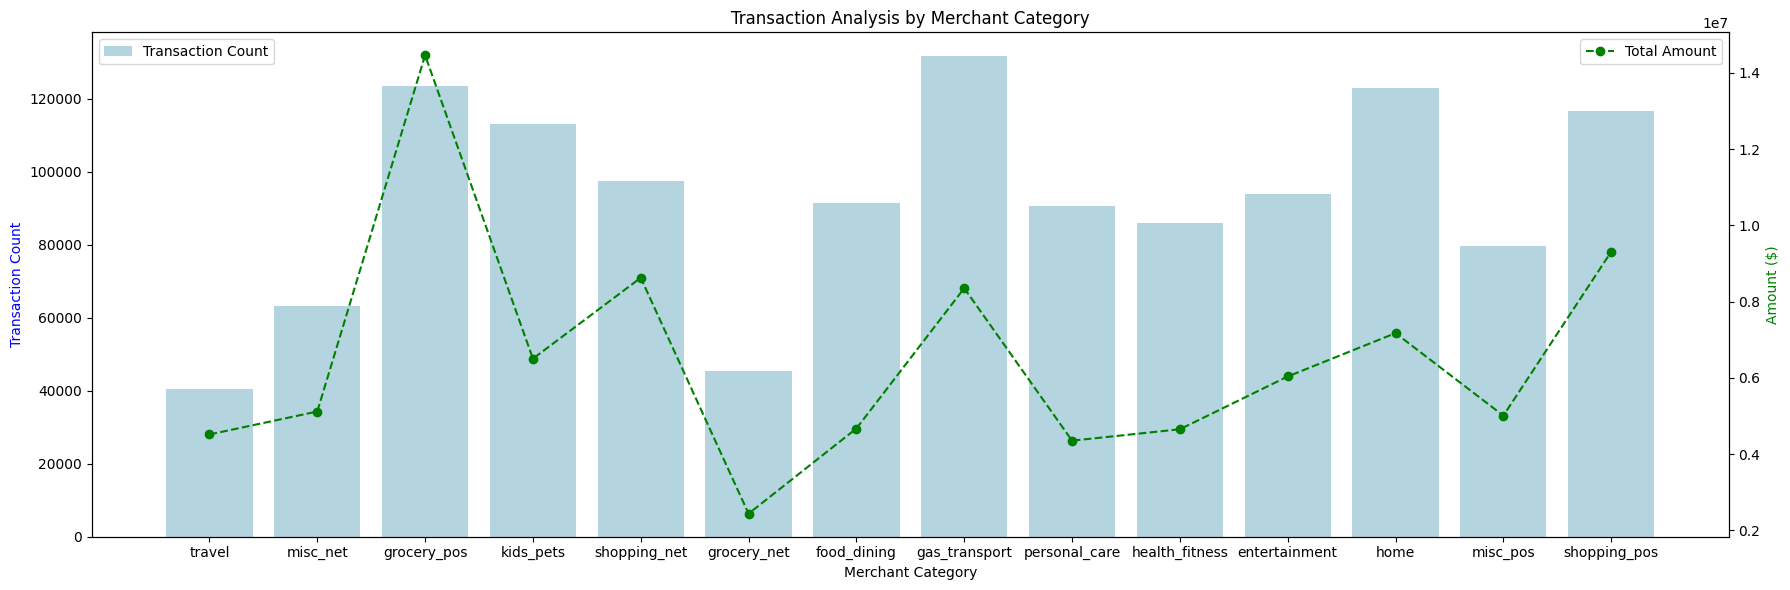

In [14]:
fig, ax1 = plt.subplots(figsize=(18, 6))
sns.barplot(x='category', y='count', data=pd_df, ax=ax1, color='lightblue', label='Transaction Count')
ax2 = ax1.twinx()
ax2.plot(pd_df['category'],pd_df['sum'], color='green', marker='o', linestyle='dashed', label='Total Amount')
ax1.set_xlabel('Merchant Category')
ax1.set_ylabel('Transaction Count', color='blue')
ax2.set_ylabel('Amount ($)', color='green')
plt.title('Transaction Analysis by Merchant Category')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Analysing which categories contain the most high value items and high value purchases

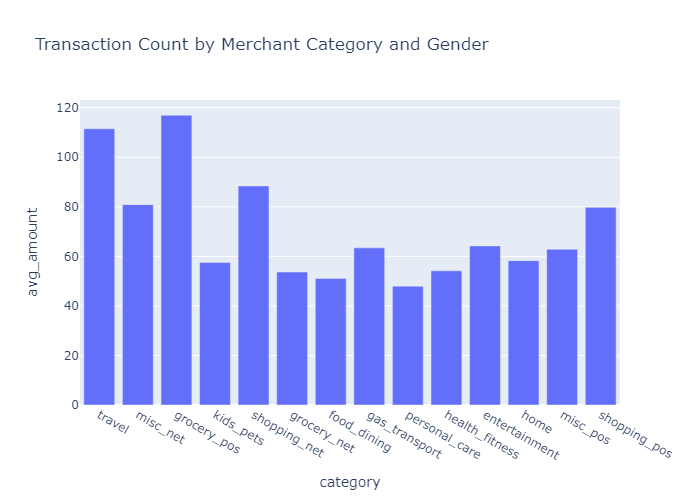

In [15]:
fig = px.bar(
    pd_df,
    x='category',
    y='avg_amount',
    title='Transaction Count by Merchant Category and Gender',
    labels={'merchant_category': 'Merchant Category', 'transaction_count': 'Transaction Count'}
)

# fig.show() #uncomment for interactivity in Jupyter nb
fig.write_image("plot.png")
img = Image.open("plot.png")
display(img)

Using plotly express to map out transaction volume according to each US state.
Similarly, will use dataframe containing only fraud positive transactions to see if there are any correlations.

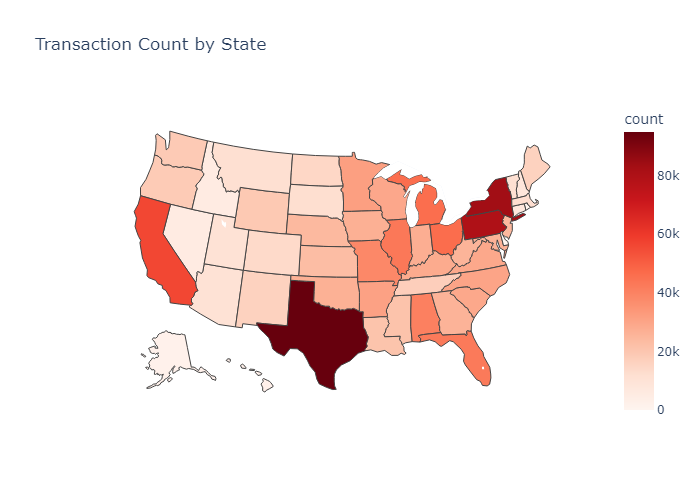

In [16]:
fig1 = px.choropleth(state_df, 
                    locations='state', 
                    locationmode='USA-states', 
                    color='count', 
                    color_continuous_scale='Reds',
                    scope='usa',
                    title='Transaction Count by State')

# fig1.show() #uncomment for interactivity in Jupyter nb
fig1.write_image("plot.png")
img1 = Image.open("plot.png")
display(img1)

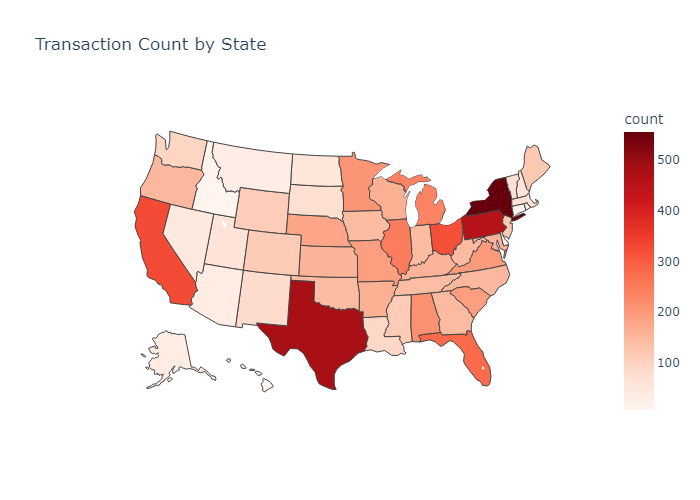

In [17]:
fig2 = px.choropleth(fr_s_df, 
                    locations='state', 
                    locationmode='USA-states', 
                    color='count', 
                    color_continuous_scale='Reds',
                    scope='usa',
                    title='Transaction Count by State')

# fig2.show() #uncomment for interactivity in Jupyter nb
fig2.write_image("plot.png")
img2 = Image.open("plot.png")
display(img2)

Wanting to see the correlations between spending and gender. From graph it shows that women represent the majority purchasing power regardless of category.

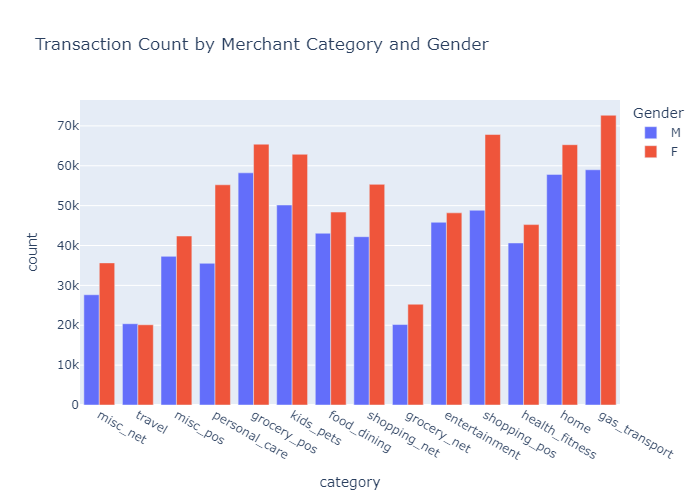

In [18]:
fig3 = px.bar(
    mf_df,
    x='category',
    y='count',
    color='gender',
    barmode='group',
    title='Transaction Count by Merchant Category and Gender',
    labels={'merchant_category': 'Merchant Category', 'transaction_count': 'Transaction Count', 'gender': 'Gender'}
)

# fig3.show()
fig3.write_image("plot.png")
img3 = Image.open("plot.png")
display(img3)

Analyzing correlation between fraud and categories to determine which categories have the highest percentage of fraud.

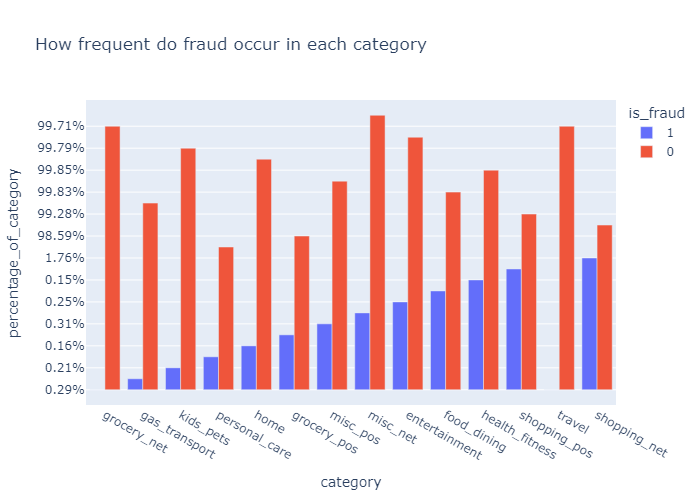

In [19]:
fig4 = px.bar(
    fr_c_df,
    x='category',
    y='percentage_of_category',
    color='is_fraud',
    barmode='group',
    title='How frequent do fraud occur in each category',
)

# fig4.show()
fig4.write_image("plot.png")
img4 = Image.open("plot.png")
display(img4)